In [1]:
include("CRNevo.jl")
include("CRNExplore.jl")
include("SymbolicOps.jl")

# --- GA parameters
genetic_pool_size = 1000
elite = 100
worst = 200
death_rate = 0.05
mutation_rate = 0.30
gradient_mutation_rate = 0.01
duplication_rate = 0.20
crossover_rate = 0.
max_generations = 100
p_cross = 0.1

# --- GD parameters

# fixed, basic steps

N = 3
np = count_parameters(N)
target = N
crn = create_reactions(N)
ode_crn = convert(ODESystem, crn)
pars_l = assemble_opt_parameters_and_varables([0 for _ in 1:np], N) # just for the names
ext_ode = make_sensitivity_ode(ode_crn, pars_l.p)
t0 = 10.0
t1 = 20.0

# set up gd problem 

crn_info = (
    crn = crn, 
    ode_crn = ode_crn,
    ext_ode = ext_ode,
    np = np,
    N = N,
    target = target
)

# set up the loss function

gd_loss_options = (
    weights = [100., 1., 0.001, 5], #[2.0, 1.0/3, 1.0/80, 100.0], #[1., 0.01, 0.01, 1.] # this descends smoothly
    p=0.01,
    d=0.5,
    f_ss=0.5,
    norm_for_sensitivity_loss = 1, 
    norm_for_ss_loss = 1,
    norm_for_adaptation_loss = 1,
    n_losses = 4
)

loss_blueprint = prepare_args(nothing, target, t0, t1, pars_l, gd_loss_options.weights, gd_loss_options.p, gd_loss_options.d, gd_loss_options.f_ss, gd_loss_options.norm_for_sensitivity_loss, gd_loss_options.norm_for_ss_loss, gd_loss_options.norm_for_adaptation_loss)

gd_options = (
    alpha = 0.1,
    n_iter = 10,
    use_pruning_heuristic = false,
    clip_value = nothing,
    use_gradient_normalization = false,
    use_adagrad = true, # overrides use_adam!
    use_adam = false,
    use_random_perturbation = false,
    verbose = false,
    # placed here for convenience, should be in gd_loss_options
    symbolic_derivatives_of_loss = compute_symbolic_derivatives_of_loss(total_loss_symbolic(loss_blueprint))
)

gd_perturbation_options = (
    t0 = t0,
    t1 = t1,
    input = 1.,
    perturbation = 1.,
    K = 5,
    perturbation_list = [-1., -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1., 2., 3., 4., 5., 6., 7., 8., 9., 10.],
    loss_blueprint = loss_blueprint
)


#s_loss = stochastic_loss(K, prob, perturb!, tspan, target, tspan[2]/2., tspan[2], sensitivity_dt, sensitivity_offset, steady_d, l1, l2, l3, l4, absolute, rtol, atol, maxiters)
#mutate_with_GD = (p) -> gradient_descent(ALPHA, NITER, p, s_loss, true, false, 0.01/ALPHA, use_adagrad).minimizer
mutate_with_GD = (p) -> symbolic_gradient_descent(p, crn_info, gd_options, gd_perturbation_options, gd_loss_options).parameters
function make_ev_loss(crn_info, gd_options, gd_perturbation_options, gd_loss_options)
    function ev_loss(p)
        pars_l = assemble_opt_parameters_and_varables(p, crn_info.N)
        solutions = run_with_fixed_perturbations(crn_info.crn, p, pars_l, gd_perturbation_options.input,  gd_perturbation_options.perturbation_list, gd_perturbation_options.t0, gd_perturbation_options.t1)
        losses = zeros(length(solutions))
        Threads.@threads for i in 1:length(solutions)
            loss_args = update_args(solutions[i], crn_info.target, gd_perturbation_options.t0, gd_perturbation_options.t1, pars_l, gd_perturbation_options.loss_blueprint, gd_loss_options.p, gd_loss_options.d, gd_loss_options.f_ss) 
            losses[i] = total_loss_eval(loss_args).total.val
        end
        return sum(losses)/length(gd_perturbation_options.perturbation_list)
    end
    return ev_loss
end
loss_function = make_ev_loss(crn_info, gd_options, gd_perturbation_options, gd_loss_options)
print("setup done!")


setup done!

In [2]:
# for i in 1:100
#     loss_function([1 for _ in 1:np])
# end

In [4]:
println("Testing symbolic gradient descent")
println(loss_function([1 for _ in 1:np]))
test_p = symbolic_gradient_descent([1 for _ in 1:np], crn_info, gd_options, gd_perturbation_options, gd_loss_options)
println(loss_function(test_p.parameters))

Testing symbolic gradient descent
0.5102111251989166
0.501067797338419


initialize the GA problem 

In [21]:
parameter_pool = [[rand() for _ in 1:np] for _ in 1:genetic_pool_size]
is_updated = [false for _ in 1:genetic_pool_size]
fitness = [0. for _ in 1:genetic_pool_size]

dp = 0.05

state = (pool = parameter_pool, is_updated = is_updated, fitness = fitness, history = (best_loss = [], mean_loss = []))
print("done")

done

In [ ]:
using ProgressBars
max_generations = 1000
for i in ProgressBar(1:max_generations)
    state = symbolic_evolve(crn, loss_function, state, dp, genetic_pool_size, elite, worst, death_rate, mutation_rate, gradient_mutation_rate, mutate_with_GD, duplication_rate, crossover_rate, p_cross)
end

In [124]:
minimum(state.history.mean_loss)

0.0602607189605919

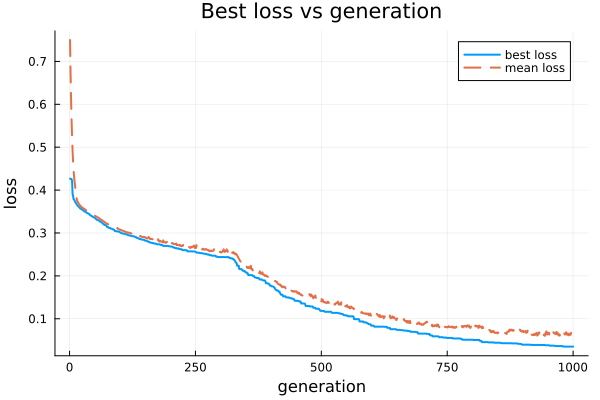

In [114]:
plot(state.history.best_loss, label="best loss", xlabel="generation", ylabel="loss", title="Best loss vs generation", lw=2, legend=:topright)
plot!(state.history.mean_loss, label="mean loss", lw=2, line=:dash)

In [24]:
best = argmin(state.fitness)
println("Best loss: ", state.fitness[best])

Best loss: 0.03512834699348577


Optimal index: 1
Adaptation error: 0.0022870740614613916
sensitivity: 0.051228502064580295 and  loss : 0.04122850206458029


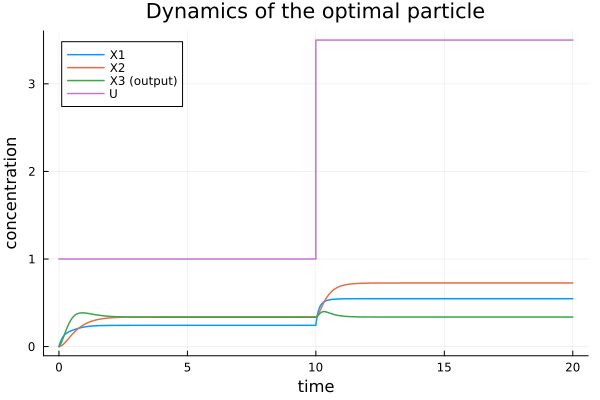

In [140]:
perturb = 2.5
opt_index = 1#best
#opt_index = 10

opt_pars_v = state.pool[opt_index]
opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)

sol = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, 1., [ perturb ], t0, t1)[1]
println("Optimal index: ", opt_index)
println("Adaptation error: ", abs(sol(t0)[3] - sol(t1)[3]))
println("sensitivity: ", abs(sol(t0)[3] - sol(t0+0.5)[3]), " and  loss : ", abs(abs(sol(t0)[3] - sol(t0+0.5)[3]) - 0.01))
plot(sol.t, vec2mat(sol.u)[:,1:4], label=["X1" "X2" "X3 (output)" "U"], lw=1.5, title="Dynamics of the optimal particle", xlabel="time", ylabel="concentration")

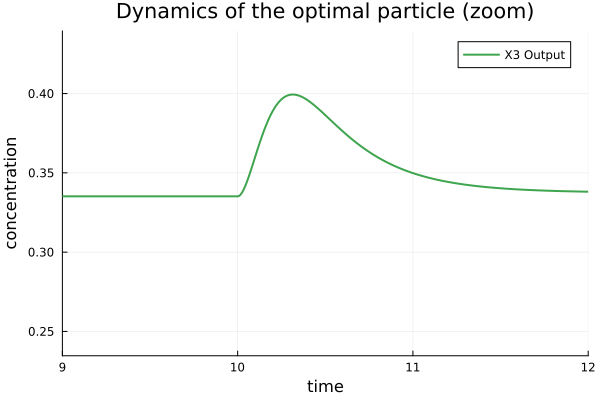

In [143]:
# zoom on reaction 3
plot(sol.t, vec2mat(sol.u)[:,3], label="X3 Output", xlabel="time", ylabel="concentration", title="Dynamics of the optimal particle (zoom)", lw=2, color=3)
xlims!(t0-1., t0+2)
ylims!(sol(t0-1)[3]-sol(t0-1)[3]*0.3, sol(t0+2)[3]+sol(t0+2)[3]*0.3)

In [ ]:
gd_options_for_output = (
    alpha = gd_options.alpha,
    n_iter = gd_options.n_iter,
    use_pruning_heuristic = gd_options.use_pruning_heuristic,
    clip_value = gd_options.clip_value,
    use_gradient_normalization = gd_options.use_gradient_normalization,
    use_adagrad = gd_options.use_adagrad, # overrides use_adam!
    use_adam = gd_options.use_adam,
    use_random_perturbation = gd_options.use_random_perturbation,
    verbose = true,
    # placed here for convenience, should be in gd_loss_options
    symbolic_derivatives_of_loss = gd_options.symbolic_derivatives_of_loss
)
out = symbolic_gradient_descent(state.pool[best], crn_info, gd_options_for_output, gd_perturbation_options, gd_loss_options)

In [ ]:
plot(1:length(out.loss_tape), out.loss_tape, label="loss", xlabel="iteration", ylabel="loss", title="Loss vs iteration", lw=2, legend=:bottomright)

In [57]:
using Symbolics
using LinearAlgebra
function joint_jacobian(i, j, jac, initial_conditions)
    A_ij = substitute(jac[i, j], unsym_dict(initial_conditions))
    return A_ij
end

opt_index = 1
# opt_index = argmin(predictions)
# opt_index = length(loss_tape)

opt_pars_v = state.pool[opt_index]
opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)

jac = Symbolics.substitute(calculate_jacobian(ode_crn), unsym_dict(opt_pars_l.p))

perturb = 2.5
steady_state_after_perturbation = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, 1., [ perturb ], t0, t1)[1](t1)[1:3]
steady_state_after_perturbation = [
    :x_1 => steady_state_after_perturbation[1],
    :x_2 => steady_state_after_perturbation[2],
    :x_3 => steady_state_after_perturbation[3]
]

A_21 = joint_jacobian(2, 1, jac, steady_state_after_perturbation)
A_32 = joint_jacobian(3, 2, jac, steady_state_after_perturbation)
A_22 = joint_jacobian(2, 2, jac, steady_state_after_perturbation)
A_31 = joint_jacobian(3, 1, jac, steady_state_after_perturbation)

println("A_21 = ", A_21)
println("A_32 = ", A_32)
println("A_22 = ", A_22)
println("A_31 = ", A_31)
println("A_22*A_31 = ", A_22*A_31)
println("A_21*A_32 = ", A_21*A_32)
println("A_22*A_31 - A_21*A_32 = ", A_22*A_31 - A_21*A_32)

A_21 = 4.696726863653503
A_32 = -2.7484978613194597
A_22 = -3.6427069002324917
A_31 = 3.6193027584856856
A_22*A_31 = -13.184059132366299
A_21*A_32 = -12.908943739953308
A_22*A_31 - A_21*A_32 = -0.27511539241299054


In [66]:
homeostatic_coefs_A21_A32 = []
homeostatic_coefs_A22_A31 = []
homeostatic_coefs = []

for par_set in state.pool
    opt_pars_v = par_set
    opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, N)

    jac = Symbolics.substitute(calculate_jacobian(ode_crn), unsym_dict(opt_pars_l.p))

    perturb = 2.5
    steady_state_after_perturbation = run_extended_with_fixed_perturbations(ext_ode, opt_pars_l, 1., [ perturb ], t0, t1)[1](t1)[1:3]
    steady_state_after_perturbation = [
        :x_1 => steady_state_after_perturbation[1],
        :x_2 => steady_state_after_perturbation[2],
        :x_3 => steady_state_after_perturbation[3]
    ]

    A_21 = joint_jacobian(2, 1, jac, steady_state_after_perturbation)
    A_32 = joint_jacobian(3, 2, jac, steady_state_after_perturbation)
    A_22 = joint_jacobian(2, 2, jac, steady_state_after_perturbation)
    A_31 = joint_jacobian(3, 1, jac, steady_state_after_perturbation)

    push!(homeostatic_coefs_A21_A32, A_21*A_32)
    push!(homeostatic_coefs_A22_A31, A_22*A_31)
    push!(homeostatic_coefs, A_22*A_31 - A_21*A_32)
end

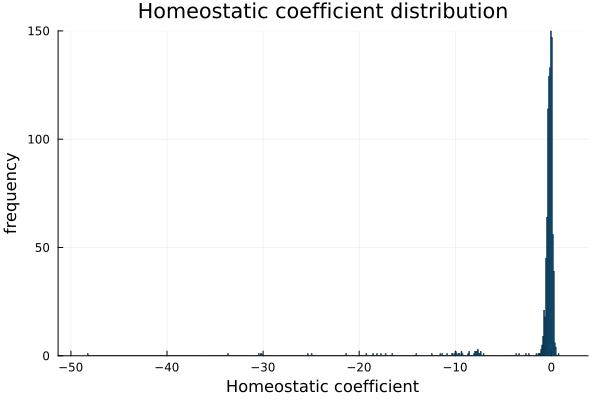

In [144]:
histogram([x.val for x in homeostatic_coefs], label=false, xlabel="Homeostatic coefficient", ylabel="frequency", title="Homeostatic coefficient distribution", lw=0.5, legend=:bottomright)

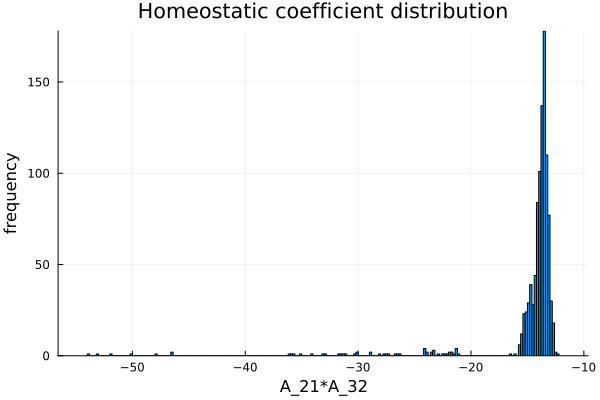

In [133]:
histogram([x.val for x in homeostatic_coefs_A21_A32], label=false, xlabel="A_21*A_32", ylabel="frequency", title="Homeostatic coefficient distribution", lw=1, legend=:bottomright)

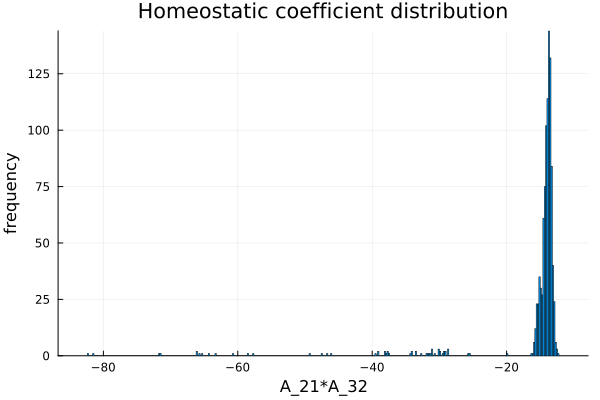

In [135]:
histogram([x.val for x in homeostatic_coefs_A22_A31], label=false, xlabel="A_21*A_32", ylabel="frequency", title="Homeostatic coefficient distribution", lw=0.5, legend=:bottomright)

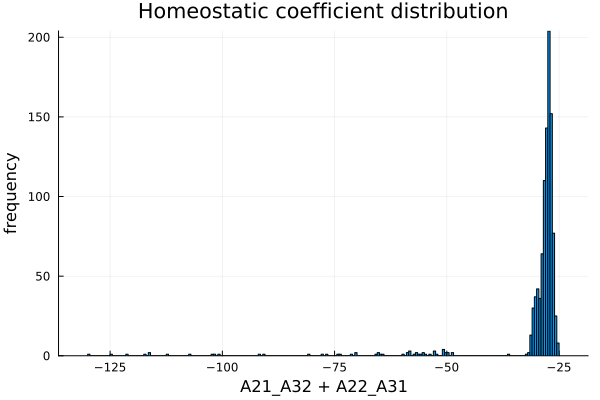

In [137]:
histogram([ x.val for x in homeostatic_coefs_A21_A32 + homeostatic_coefs_A22_A31], xlabel="A21_A32 + A22_A31", ylabel="frequency", title="Homeostatic coefficient distribution", lw=1, legend=false)

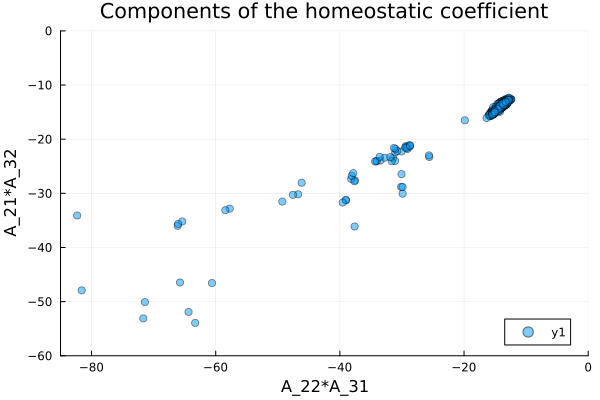

In [126]:
plot([x.val for x in homeostatic_coefs_A22_A31], [x.val for x in homeostatic_coefs_A21_A32], seriestype = :scatter, xlabel="A_22*A_31", ylabel="A_21*A_32", title="Components of the homeostatic coefficient", lw=2, legend=:bottomright, alpha=0.5)
xlims!(-85,0)
ylims!(-60,0)

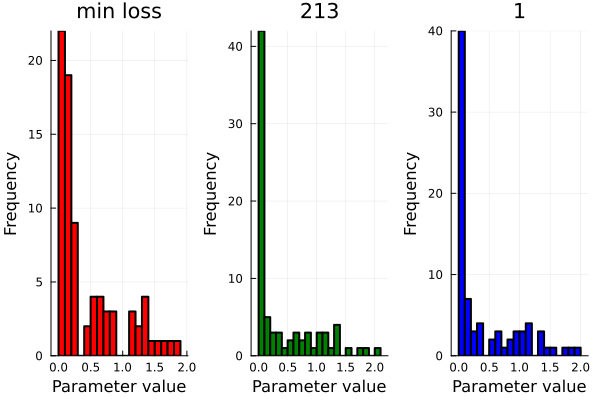

In [112]:
opt_index_options = [best, rand(1:length(state.pool)), 1]
opt_index_options_labels = ["min loss", "$(opt_index_options[2])", "1"]
opt_index_options_colors = [:red, :green, :blue]

hists = []
for i in 1:length(opt_index_options)
    opt_index = opt_index_options[i]
    opt_pars_v = state.pool[opt_index]
    opt_pars_l = assemble_opt_parameters_and_varables(opt_pars_v, 3)
    h = histogram(opt_pars_v, label=opt_index_options_labels[i], xlabel="Parameter value", ylabel="Frequency", title=opt_index_options_labels[i], lw=2, legend=false, color=opt_index_options_colors[i], bins=20)
    push!(hists, h)
end
plot(hists..., layout=(1,3))

In [151]:
using Pkg; Pkg.add("JLD2")

    Updating registry at `~/.julia/registries/General.toml`


   Resolving package versions...


   Installed JLD2 ─ v0.4.46


    Updating `~/.julia/environments/v1.10/Project.toml`
  [033835bb] + JLD2 v0.4.46
    Updating `~/.julia/environments/v1.10/Manifest.toml`


  [033835bb] + JLD2 v0.4.46


Precompiling 

project...


  ✓ JLD2
  1 dependency successfully precompiled in 20 seconds. 466 already precompiled.


In [154]:
using JLD2

save_object("IFF-finding-run.jld2", Dict(
    "state" => state,
    # all parameters 
    "ga_options" => Dict(
        genetic_pool_size => genetic_pool_size,
        elite => elite,
        worst => worst,
        death_rate => death_rate,
        mutation_rate => mutation_rate,
        gradient_mutation_rate => gradient_mutation_rate,
        duplication_rate => duplication_rate,
        crossover_rate => crossover_rate,
        max_generations => max_generations,
        p_cross => p_cross
    ),
    "crn_info" => crn_info,
    "gd_loss_options" => gd_loss_options,
    "gd_options" => gd_options,
    "gd_perturbation_options" => gd_perturbation_options
))    


In [155]:
test_load = load_object("IFF-finding-run.jld2") 

Dict{String, Any} with 6 entries:
  "crn_info"                => (crn = ReactionSystem{NetworkProperties{Int64, B…
  "gd_perturbation_options" => (t0 = 10.0, t1 = 20.0, input = 1.0, perturbation…
  "state"                   => (pool = [[0.0400214, 0.277194, 0.0, 0.0173143, 0…
  "ga_options"              => Dict{Real, Real}(0.0=>0.0, 200=>200, 0.3=>0.3, 0…
  "gd_loss_options"         => (weights = [100.0, 1.0, 0.001, 5.0], p = 0.01, d…
  "gd_options"              => (alpha = 0.1, n_iter = 10, use_pruning_heuristic…